<a href="https://colab.research.google.com/github/driano1221/ControleEst/blob/main/Decision_Trees_PL2_Group10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Construção de Árvores de Decisão para Classificação

Adriano Pires Cunha \
Diogo André Almeida Ferreira

## Introdução

Árvores de decisão são algoritmos de aprendizado supervisionado amplamente utilizados para tarefas de classificação e regressão. Esses algoritmos funcionam dividindo repetidamente os dados de entrada com base em atributos específicos para criar um modelo que pode ser usado para prever a classe ou valor de novos dados. As árvores de decisão são populares devido à sua simplicidade, interpretabilidade e capacidade de lidar com dados categóricos e numéricos.

Neste notebook, vamos explorar a construção de árvores de decisão para três conjuntos de dados distintos: um conjunto de dados de clima, um conjunto de dados de restaurante e o famoso conjunto de dados Íris. Utilizaremos a teoria de entropia e ganho de informação para construir as árvores e visualizá-las usando a biblioteca NetworkX.


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout

# Node class
class Node:
    def __init__(self, attribute=None, threshold=None, is_leaf=False, prediction=None):
        self.attribute = attribute
        self.threshold = threshold
        self.is_leaf = is_leaf
        self.prediction = prediction
        self.children = {}
        self.counter = None

A classe `Node` define a estrutura básica de um nó na árvore de decisão. Cada nó pode representar uma decisão com base em um atributo específico, um valor limite (para atributos numéricos), ou uma folha que contém a predição final. O dicionário `children` armazena os nós filhos que resultam das subdivisões.


In [ ]:
# Define entropy
def entropy(y):
    unique_classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return -np.sum(probabilities * np.log2(probabilities))

# Get information gain of possible splits
def information_gain(y, splits):
    total_entropy = entropy(y)
    weighted_entropy = 0
    total_len = len(y)

    for subset in splits:
        subset_len = len(subset)
        if subset_len > 0:
            weighted_entropy += (subset_len / total_len) * entropy(subset)

    return total_entropy - weighted_entropy

- `entropy`: A função `entropy` calcula a entropia de um conjunto de rótulos. A entropia é uma medida da impureza ou aleatoriedade dos dados. Ela é calculada usando a fórmula de entropia de Shannon, onde p é a probabilidade de cada classe. Quanto menor a entropia, mais homogêneo é o conjunto de dados.

$ \text{Entropia}(S) = - \sum_{i=1}^{c} p_i \log_2(p_i) $

onde $ p_i $ é a proporção de elementos da classe $ i $ em $ S $

- `information_gain`: A função `information_gain` calcula o ganho de informação ao dividir os dados com base em um atributo. O ganho de informação é a redução na entropia após a divisão. Ele é calculado como a diferença entre a entropia total antes da divisão e a entropia ponderada após a divisão. Quanto maior o ganho de informação, melhor é a divisão.

$ \text{Ganho de Informação} = \text{Entropia Total} - \text{Entropia Ponderada dos Subconjuntos} $



In [ ]:
# Get best split
def best_split(df, target_column):
    best_gain = -1
    best_split = None
    best_splits = None

    for column in df.columns:
        if column == target_column:
            continue
        values = df[column]

        # Check if column is numeric (int or float) but not boolean
        if np.issubdtype(values.dtype, np.number) and not np.issubdtype(values.dtype, np.bool_):
            thresholds = values.sort_values().unique()
            for threshold in thresholds:
                df_left = df[df[column] <= threshold]
                df_right = df[df[column] > threshold]
                if len(df_left) == 0 or len(df_right) == 0:
                    continue
                y, y_left, y_right = df[target_column], df_left[target_column], df_right[target_column]
                gain = information_gain(y, [y_left, y_right])
                if gain > best_gain:
                    best_gain = gain
                    best_split = (column, threshold)
                    best_splits = (df_left, df_right)
        else:
            categories = values.unique()
            splits = {category: df[df[column] == category] for category in categories}
            y_splits = [split[target_column] for split in splits.values()]
            gain = information_gain(df[target_column], y_splits)
            if gain > best_gain:
                best_gain = gain
                best_split = (column, None)
                best_splits = splits

    return best_split, best_splits

# Create decision tree
def build_tree(df, target_column, depth=0):
    y = df[target_column]
    if len(y.unique()) == 1:
        leaf = Node(is_leaf=True, prediction=y.iloc[0])
        leaf.counter = len(y)
        return leaf
    if df.shape[1] == 1:  # Only the target column left
        prediction = y.mode()[0]
        leaf = Node(is_leaf=True, prediction=prediction)
        leaf.counter = len(y)
        return leaf

    split, splits = best_split(df, target_column)
    if not split:
        prediction = y.mode()[0]
        leaf = Node(is_leaf=True, prediction=prediction)
        leaf.counter = len(y)
        return leaf

    root = Node(attribute=split[0], threshold=split[1])
    if split[1] is not None:  # Numerical split
        root.children['<='] = build_tree(splits[0], target_column, depth + 1)
        root.children['>'] = build_tree(splits[1], target_column, depth + 1)
    else:  # Categorical split
        for category, subset in splits.items():
            root.children[category] = build_tree(subset, target_column, depth + 1)

    root.counter = len(y)
    return root

# Print tree in desired format
def print_tree(node, level=0, prefix=""):
    indent = "  " * level
    if node.is_leaf:
        print(f"{indent}{prefix}: {node.prediction} ({node.counter})")
    else:
        if node.threshold is not None:
            print(f"{indent}<{node.attribute}>")
            print_tree(node.children['<='], level + 1, f"<= {node.threshold}")
            print_tree(node.children['>'], level + 1, f"> {node.threshold}")
        else:
            print(f"{indent}<{node.attribute}>")
            for category, child in node.children.items():
                if child.is_leaf:
                    print(f"{indent}  {category}: {child.prediction} ({child.counter})")
                else:
                    print(f"{indent}  {category}")
                    print_tree(child, level + 1, prefix=f"{category}")

- `best_split`: A função `best_split` encontra a melhor divisão para um determinado conjunto de dados. Ela itera sobre todas as colunas (exceto a coluna alvo) e calcula o ganho de informação para cada possível divisão. Para atributos numéricos, ela considera todos os valores únicos como possíveis limiares. Para atributos categóricos, ela divide os dados com base nas categorias. A divisão com o maior ganho de informação é selecionada.

- `build_tree`: A função `build_tree` constrói recursivamente a árvore de decisão. Ela verifica as condições de parada (todos os rótulos são iguais ou apenas a coluna alvo está presente) e cria um nó folha nesses casos. Caso contrário, ela encontra a melhor divisão usando a função `best_split` e cria um nó interno. Em seguida, chama recursivamente a função `build_tree` para cada subconjunto resultante da divisão.

In [ ]:
# Create graph for decision tree visualisation
def add_edges(graph, node, parent_id=None, edge_label=''):
    node_id = id(node)
    if node.is_leaf:
        node_label = f"{node.prediction} ({node.counter})"
    else:
        node_label = f"{node.attribute}"
    graph.add_node(node_id, label=node_label)
    if parent_id is not None:
        graph.add_edge(parent_id, node_id, label=edge_label)
    for key, child in node.children.items():
        if node.threshold is not None:
            child_edge_label = f"{key} {node.threshold}"
        else:
            child_edge_label = str(key)
        add_edges(graph, child, node_id, child_edge_label)

def visualize_tree_with_networkx(node):
    graph = nx.DiGraph()
    add_edges(graph, node)
    pos = graphviz_layout(graph, prog='dot')
    edge_labels = nx.get_edge_attributes(graph, 'label')
    labels = nx.get_node_attributes(graph, 'label')

    plt.figure(figsize=(10, 6))
    nx.draw(graph, pos, labels=labels, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=25)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_color='red')
    plt.show()

# Get a prediction from the decision tree, considering the situation given
def predict(node, sample):
    while not node.is_leaf:
        attribute_value = sample[node.attribute]
        if node.threshold is not None:  # Numerical split
            if attribute_value <= node.threshold:
                node = node.children['<=']
            else:
                node = node.children['>']
        else:  # Categorical split
            if attribute_value in node.children:
                node = node.children[attribute_value]
            else:
                return None  # Unable to classify if unseen category
    return node.prediction

# Load data
data_restaurant = pd.read_csv('restaurant.csv')
data_weather = pd.read_csv('weather.csv')
data_iris = pd.read_csv('iris.csv')
data_connect4 = pd.read_csv('connect4.csv')

# Use the first column as the ID and the last column as the target
data_restaurant = data_restaurant.drop(data_restaurant.columns[0], axis=1)
data_weather = data_weather.drop(data_weather.columns[0], axis=1)
data_iris = data_iris.drop(data_iris.columns[0], axis=1)

target_column_restaurant = data_restaurant.columns[-1]
target_column_weather = data_weather.columns[-1]
target_column_iris = data_iris.columns[-1]

# Convert None value to actual "None" string
data_restaurant = data_restaurant.where(pd.notnull(data_restaurant), "None")

# Build the decision trees
tree_restaurant = build_tree(data_restaurant, target_column_restaurant)
tree_weather = build_tree(data_weather, target_column_weather)
tree_iris = build_tree(data_iris, target_column_iris)

# Print the decision trees
print("Restaurant decision tree")
print_tree(tree_restaurant)
print("\n ----- // ----- // ----- \n")
print("Weather decision tree")
print_tree(tree_weather)
print("\n ----- // ----- // ----- \n")
print("Iris decision tree")
print_tree(tree_iris)

Restaurant decision tree
<Pat>
  Some: Yes (4)
  Full
  <Hun>
    Yes
    <Type>
      Thai
      <Fri>
        No: No (1)
        Yes: Yes (1)
      Italian: No (1)
      Burger: Yes (1)
    No: No (2)
  None: No (2)

 ----- // ----- // ----- 

Weather decision tree
<Weather>
  sunny
  <Humidity>
    <= 70: yes (2)
    > 70: no (3)
  overcast: yes (4)
  rainy
  <Windy>
    False: yes (3)
    True: no (2)

 ----- // ----- // ----- 

Iris decision tree
<petallength>
  <= 1.9: Iris-setosa (50)
  <petalwidth>
    <petallength>
      <petalwidth>
        <= 1.6: Iris-versicolor (47)
        > 1.6: Iris-virginica (1)
      <petalwidth>
        <= 1.5: Iris-virginica (3)
        <sepallength>
          <= 6.7: Iris-versicolor (2)
          > 6.7: Iris-virginica (1)
    <petallength>
      <sepallength>
        <= 5.9: Iris-versicolor (1)
        > 5.9: Iris-virginica (2)
      > 4.8: Iris-virginica (43)


### Visualização da Árvore com NetworkX
Essas funções adicionam os nós e arestas da árvore de decisão a um grafo `networkx` e utilizam `graphviz` para criar uma disposição hierárquica. Em seguida, desenham o grafo com `matplotlib`.


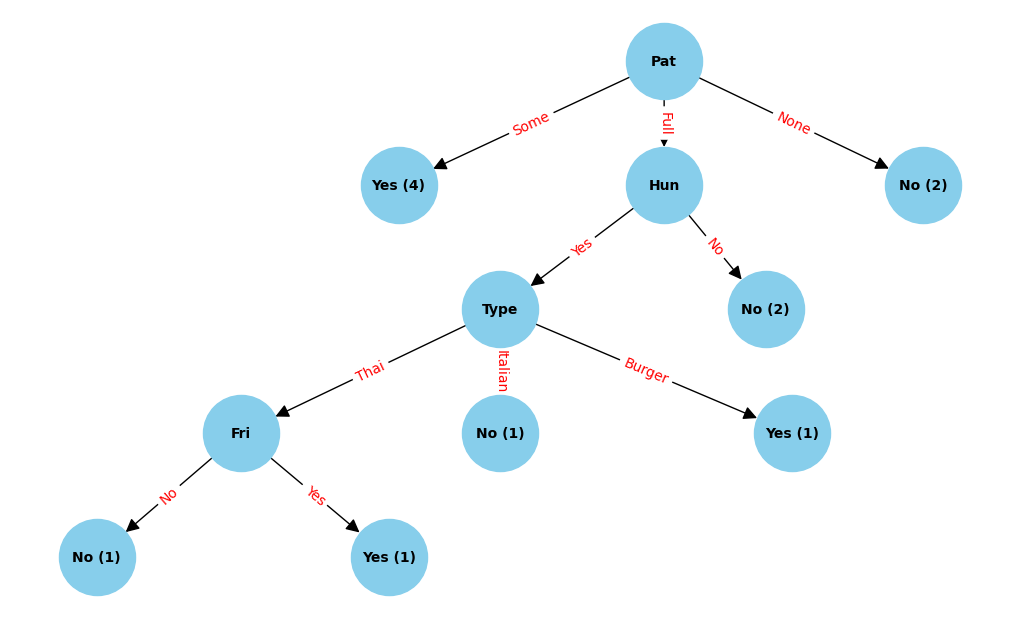

-----


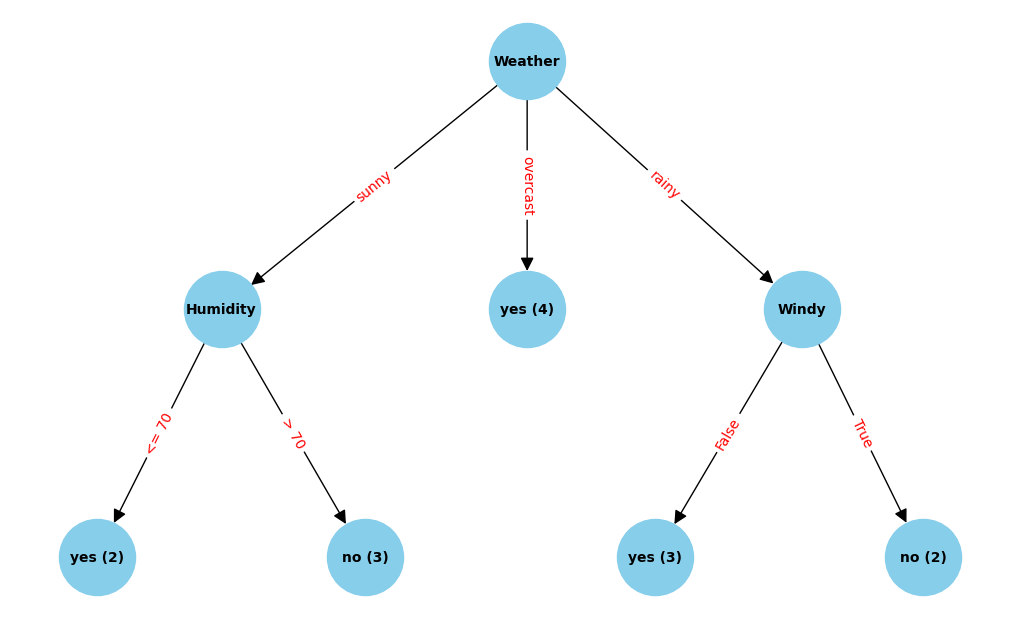

-----


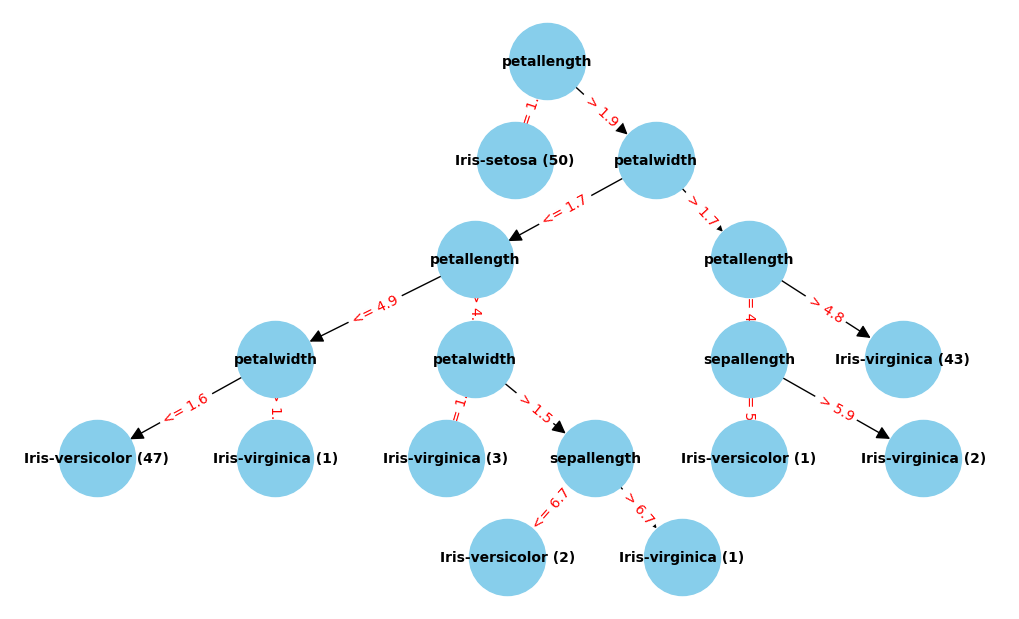

In [ ]:
# Visualize the decision trees with networkx
visualize_tree_with_networkx(tree_restaurant)
print("-----") # Separate the trees
visualize_tree_with_networkx(tree_weather)
print("-----")
visualize_tree_with_networkx(tree_iris)

Aplicamos o algoritmo de árvore de decisão a três conjuntos de dados diferentes: restaurante, clima e íris. Para cada conjunto de dados, construímos uma árvore de decisão e a visualizamos usando a biblioteca networkx.

- **Conjunto de dados do restaurante**: A árvore de decisão resultante usa os atributos "Pat", "Hun", "Type" e "Fri" para prever se um cliente vai ou não a um restaurante. Ela consegue capturar as regras de decisão com base nas características fornecidas.

- **Conjunto de dados do clima**: A árvore de decisão resultante usa os atributos "Weather", "Humidity" e "Windy" para prever se é possível jogar tênis com base nas condições climáticas. Ela aprende as condições ideais para jogar tênis a partir dos dados de treinamento.

- **Conjunto de dados da íris**: A árvore de decisão resultante usa os atributos "petallength", "petalwidth" e "sepallength" para classificar as espécies de íris (Iris-setosa, Iris-versicolor ou Iris-virginica). Ela consegue distinguir as diferentes espécies com base nas características das pétalas e sépalas.

Além disso, implementamos uma função de previsão que permite fazer previsões com base nas árvores de decisão construídas. Demonstramos isso solicitando ao usuário informações sobre as condições climáticas e fazendo uma previsão se é possível jogar tênis ou não e solicitando informações sobre as condições de espera para fazer uma previsão se irá esperar ou não.

In [ ]:
# Parsing the input string to create a dictionary of attributes
def parse_input(input_str, column_names):
    values = input_str.split(',')
    parsed_values = []
    for value in values:
        if value.isdigit():
            parsed_values.append(int(value))
        elif value.replace('.', '', 1).isdigit():
            parsed_values.append(float(value))
        elif value.upper() == "TRUE":
            parsed_values.append(True)
        elif value.upper() == "FALSE":
            parsed_values.append(False)
        else:
            parsed_values.append(value)
    return {column_name: parsed_value for column_name, parsed_value in zip(column_names, parsed_values)}

# Ask the user about the weather conditions
weather_test = input("How's the weather? (sunny/overcast/rainy) ")
temp_test = input("What's the temperature? (numeric) ")
humidity_test = input("How about humidity? (0-100) ")
windy_test = input("Is it windy? (True/False) ")
str_weather_test = weather_test + "," + temp_test + "," + humidity_test + "," + windy_test

# Parse the input string for the weather dataset
sample_weather = parse_input(str_weather_test, data_weather.columns[:-1])

# Predict the class for the sample using the weather decision tree
classification_weather = predict(tree_weather, sample_weather)

if classification_weather == "no":
      print("You won't be able to play tennis today.")
elif classification_weather == "yes":
    print("You might be able to play tennis today.")
else:
    print("There isn't enough data to tell you if you might be able to play tennis today.")

How's the weather? (sunny/overcast/rainy) sunny
What's the temperature? (numeric) 70
How about humidity? (0-100) 50
Is it windy? (True/False) False
You might be able to play tennis today.


In [ ]:
# Ask the user about the waiting situation
alt_test = input("Is there a restaurant nearby? (Yes/No) ")
bar_test = input("Does the restaurant have a bar area to wait in? (Yes/No) ")
fri_sat_test = input("Is it Friday or Saturday? (Yes/No) ")
hungry_test = input("Are you hungry? (Yes/No) ")
pat_test = input("How many people are in the restaurant? (None/Some/Full) ")
price_test = input("How expensive is the restaurant? ($/$$/$$$) ")
rain_test = input("Is it raining? (Yes/No) ")
res_test = input("Do you have a reservation? (Yes/No) ")
type_test = input("What's the type of restaurant you are in? (French/Italian/Thai/Burger) ")
wait_test = input("What was the host's estimate wait? (0-10/10-30/30-60/>60) ")
str_restaurant_test = alt_test + "," + bar_test + "," + fri_sat_test + "," + hungry_test + "," + pat_test + "," + price_test + "," + rain_test + "," + res_test + "," + type_test + "," + wait_test

# Parse the input string for the restaurant dataset
sample_restaurant = parse_input(str_restaurant_test, data_restaurant.columns[:-1])

# Predict the class for the sample using the restaurant decision tree
classification_weather = predict(tree_restaurant, sample_restaurant)

if classification_weather == "No":
      print("I don't think you will wait.")
elif classification_weather == "Yes":
      print("I think you will wait.")
else:
      print("There isn't enough data to guess if you will wait.")

Is there a restaurant nearby? (Yes/No) No
Does the restaurant have a bar area to wait in? (Yes/No) Yes
Is it Friday or Saturday? (Yes/No) No
Are you hungry? (Yes/No) No
How many people are in the restaurant? (None/Some/Full) Some
How expensive is the restaurant? ($/$$/$$$) $
Is it raining? (Yes/No) Yes
Do you have a reservation? (Yes/No) No
What's the type of restaurant you are in? (French/Italian/Thai/Burger) Thai
What was the host's estimate wait? (0-10/10-30/30-60/>60) 0-10
I think you will wait.


Neste notebook, implementamos um algoritmo de árvore de decisão do zero usando Python e o aplicamos a diferentes conjuntos de dados. Mostramos como as árvores de decisão podem ser usadas para problemas de classificação e como elas podem fornecer insights sobre os dados.

As árvores de decisão são um método poderoso e interpretável para aprendizado de máquina supervisionado. Elas podem lidar com dados numéricos e categóricos e são capazes de capturar relações complexas nos dados.

No entanto, é importante ressaltar que o desempenho das árvores de decisão está diretamente relacionado à quantidade e qualidade dos dados de treinamento. Quanto mais dados relevantes tivermos disponíveis, melhor será a capacidade da árvore de decisão de aprender os padrões e relações subjacentes.

Aumentar o tamanho do conjunto de treinamento permite que a árvore de decisão capture uma variedade maior de cenários e tome decisões mais informadas. Com mais exemplos para aprender, a árvore pode generalizar melhor para novos dados e reduzir o risco de overfitting.

Portanto, ao trabalhar com árvores de decisão, é fundamental investir na coleta e preparação de dados de alta qualidade. Quanto mais abrangente e representativo for o conjunto de treinamento, mais confiável e precisa será a árvore de decisão resultante.

